In [3]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(".")
CSV_NAME = "bquxjob_716401ca_19974193724.csv"   

df = pd.read_csv(DATA_DIR / CSV_NAME, sep=None, engine="python", encoding="utf-8-sig")
df.head(), df.dtypes.head()

(         Order_ID  Order_Date   Ship_Date       Ship_Mode Customer_ID  \
 0  CA-2014-156587  2014-03-07  2014-03-08     First Class    AB-10015   
 1  CA-2014-156587  2014-03-07  2014-03-08     First Class    AB-10015   
 2  CA-2016-140935  2016-11-10  2016-11-12     First Class    AB-10015   
 3  CA-2016-140935  2016-11-10  2016-11-12     First Class    AB-10015   
 4  CA-2014-113768  2014-05-13  2014-05-19  Standard Class    AH-10030   
 
    Customer_Name    Segment        Country           City       State  \
 0  Aaron Bergman   Consumer  United States        Seattle  Washington   
 1  Aaron Bergman   Consumer  United States  Oklahoma City    Oklahoma   
 2  Aaron Bergman   Consumer  United States        Seattle  Washington   
 3  Aaron Bergman   Consumer  United States  Oklahoma City    Oklahoma   
 4  Aaron Hawkins  Corporate  United States    Los Angeles  California   
 
    Postal_Code   Region       Product_ID    Sales  Quantity  Discount  \
 0        98103     West  FUR-CH-1

In [4]:
#Преобразуйте даты (datetime), добавьте столбцы month, year.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
df["Ship_Date"]  = pd.to_datetime(df["Ship_Date"],  errors="coerce")
df["year"]  = df["Order_Date"].dt.year
df["month"] = df["Order_Date"].dt.month


for col in ["Sales", "Profit", "Discount", "Quantity"]:
    if col in df.columns:
        
        df[col] = (df[col]
                   .astype(str)
                   .str.replace(",", ".", regex=False)
                   .pipe(pd.to_numeric, errors="coerce"))


if "Discount" in df.columns and df["Discount"].dropna().gt(1).mean() > 0.5:
    df["Discount"] = df["Discount"] / 100.0

df.dtypes.head(20)


Order_ID                 object
Order_Date       datetime64[ns]
Ship_Date        datetime64[ns]
Ship_Mode                object
Customer_ID              object
Customer_Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal_Code               int64
Region                   object
Product_ID               object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Product_Name             object
Category                 object
Sub_Category             object
dtype: object

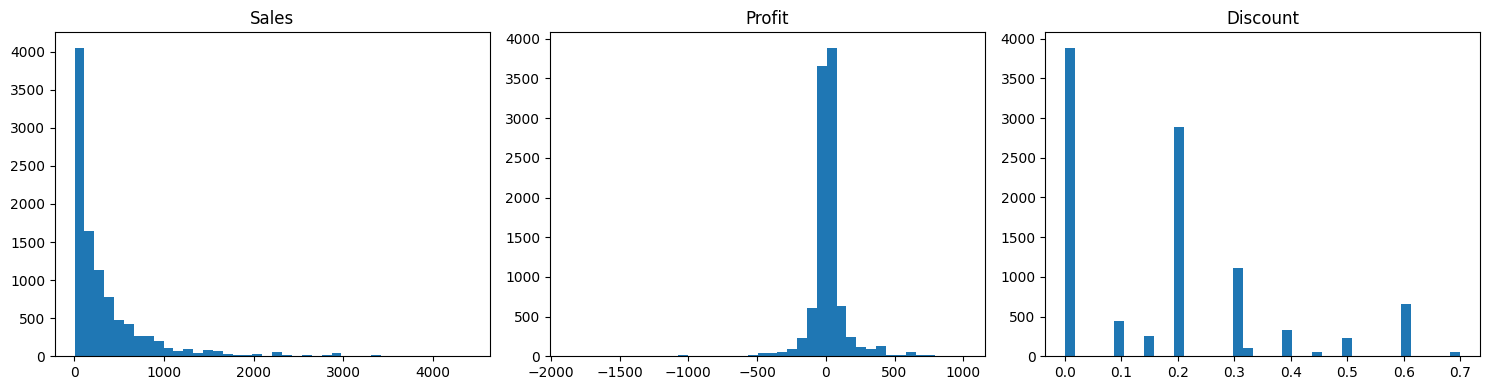

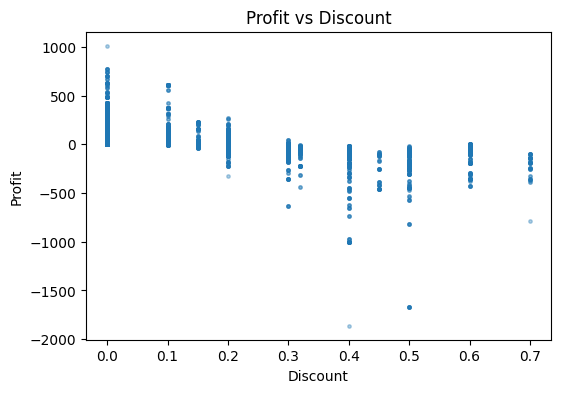

In [ ]:
#Анализ (EDA)распределение продаж, прибыли, скидок,  зависимости между скидкой и прибылью.
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(df["Sales"].dropna(), bins=40);    axes[0].set_title("Sales")
axes[1].hist(df["Profit"].dropna(), bins=40);   axes[1].set_title("Profit")
axes[2].hist(df["Discount"].dropna(), bins=40); axes[2].set_title("Discount")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["Discount"], df["Profit"], s=6, alpha=0.35)
plt.xlabel("Discount"); plt.ylabel("Profit"); plt.title("Profit vs Discount")
plt.show()



In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

for c in ["Sales","Discount","Quantity","Profit"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.replace(",", ".", regex=False).pipe(pd.to_numeric, errors="coerce")

if "Discount" in df.columns and df["Discount"].dropna().gt(1).mean() > 0.5:
    df["Discount"] = df["Discount"] / 100.0

need = ["Sales","Discount","Quantity","Profit"]
data = df[need].dropna().copy()
X = data[["Sales","Discount","Quantity"]]
y = data["Profit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred) ** 0.5:.4f}")

coefs = pd.Series(lr.coef_, index=X.columns).to_frame("coefficient")
coefs.loc["intercept"] = lr.intercept_
display(coefs)

df["profit_pred"] = np.nan
mask = df[["Sales","Discount","Quantity"]].notna().all(axis=1)
df.loc[mask, "profit_pred"] = lr.predict(df.loc[mask, ["Sales","Discount","Quantity"]])

out_cols = [c for c in [
    "Order_ID","Product_ID","Customer_ID","Order_Date","Ship_Date","Ship_Mode",
    "Sales","Quantity","Discount","Profit","profit_pred",
    "Region","Segment","City","State","Country","Category","Product_Name","Postal_Code"
] if c in df.columns]
df[out_cols].to_csv("forecast.csv", index=False, encoding="utf-8-sig")


R2: 0.3391
MAE: 61.0275
RMSE: 102.8242


,coefficient
Sales,0.054089
Discount,-358.976944
Quantity,0.188264
intercept,53.919568
